In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import warnings
import re
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import math
from matplotlib.offsetbox import AnchoredText
import pmdarima as pmd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score, accuracy_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
plt.rcParams['figure.figsize'] = (16, 8)
warnings.filterwarnings("ignore")
%matplotlib inline

In [181]:
# URL for getting the TGT
auth_url = "https://giris.epias.com.tr/cas/v1/tickets"

data = "username=***&password=***" # *** marks should be replaced with your username and password

headers = {
    "Content-type":"application/x-www-form-urlencoded",
    "Accept":"text/plain"
}
# POST request to get the TGT
response = requests.post(auth_url, data=data,headers=headers)
tgt = response.text
print(tgt)

TGT-9620389-vRTuUW--fGoNYp01BRV9ba4urihc7Zv3krcfJrWvZKjXscR-qMukhKFucS0gl1sIAog-cas-7bc549fccd-tfkqm


In [57]:
# MCP price data api url
mcp_url = "https://seffaflik.epias.com.tr/electricity-service/v1/markets/dam/data/mcp"

years = [2019, 2020, 2021, 2022, 2023]

df = pd.DataFrame()

for year in years:

    credentials = {"startDate":f"{year}-01-01T00:00:00+03:00",
                  "endDate":f"{year}-12-31T00:00:00+03:00"}
    headers = {
        "Content-type":"application/json",
        "Accept":"application/json",
        "TGT":tgt
    }
    # Send the POST request to get the TGT
    response = requests.post(mcp_url,headers=headers,json=credentials)
    mcp_json = response.json()
    df = pd.concat([df, pd.DataFrame(mcp_json["items"])])
df

,date,hour,price,priceUsd,priceEur
0,2019-01-01T00:00:00+03:00,00:00,100.38,19.01,16.61
1,2019-01-01T01:00:00+03:00,01:00,96.72,18.31,16.01
2,2019-01-01T02:00:00+03:00,02:00,81.60,15.45,13.51
3,2019-01-01T03:00:00+03:00,03:00,38.58,7.31,6.39
4,2019-01-01T04:00:00+03:00,04:00,11.52,2.18,1.91
...,...,...,...,...,...
8755,2023-12-31T19:00:00+03:00,19:00,2499.67,84.91,76.74
8756,2023-12-31T20:00:00+03:00,20:00,2472.34,83.98,75.90
8757,2023-12-31T21:00:00+03:00,21:00,2472.33,83.98,75.90
8758,2023-12-31T22:00:00+03:00,22:00,1800.00,61.15,55.26


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      43824 non-null  object 
 1   hour      43824 non-null  object 
 2   price     43824 non-null  float64
 3   priceUsd  43824 non-null  float64
 4   priceEur  43824 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.0+ MB


In [23]:
# Duplicate value check
df.duplicated().sum()

0

In [58]:
# Na value check
df.isna().sum()

date        0
hour        0
price       0
priceUsd    0
priceEur    0
dtype: int64

In [59]:
# Null value check
df.isnull().sum()

date        0
hour        0
price       0
priceUsd    0
priceEur    0
dtype: int64

In [60]:
# converting date column from object to date
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["date"].dt.hour
# Format date
df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M")
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,hour,price,priceUsd,priceEur
0,2019-01-01 00:00:00,0,100.38,19.01,16.61
1,2019-01-01 01:00:00,1,96.72,18.31,16.01
2,2019-01-01 02:00:00,2,81.60,15.45,13.51
3,2019-01-01 03:00:00,3,38.58,7.31,6.39
4,2019-01-01 04:00:00,4,11.52,2.18,1.91


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      43824 non-null  datetime64[ns]
 1   hour      43824 non-null  int64         
 2   price     43824 non-null  float64       
 3   priceUsd  43824 non-null  float64       
 4   priceEur  43824 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 2.0 MB


In [62]:
# to have statistical information about the data
df.describe().style.background_gradient(cmap='rainbow')

,hour,price,priceUsd,priceEur
count,43824.000000,43824.000000,43824.000000,43824.000000
mean,11.500000,1148.955817,77.140877,70.899604
std,6.922266,1175.042368,53.033418,52.546879
min,0.000000,0.000000,0.000000,0.000000
25%,5.750000,305.930000,42.980000,36.280000
50%,11.500000,396.610000,55.880000,50.075000
75%,17.250000,1986.930000,96.120000,87.870000
max,23.000000,4800.000000,264.170000,271.630000


In [63]:
# TL prices will be used for analyzing and models
df = df.drop(["priceUsd", "priceEur"], axis=1)
df

,date,hour,price
0,2019-01-01 00:00:00,0,100.38
1,2019-01-01 01:00:00,1,96.72
2,2019-01-01 02:00:00,2,81.60
3,2019-01-01 03:00:00,3,38.58
4,2019-01-01 04:00:00,4,11.52
...,...,...,...
8755,2023-12-31 19:00:00,19,2499.67
8756,2023-12-31 20:00:00,20,2472.34
8757,2023-12-31 21:00:00,21,2472.33
8758,2023-12-31 22:00:00,22,1800.00


<AxesSubplot:xlabel='date', ylabel='price'>

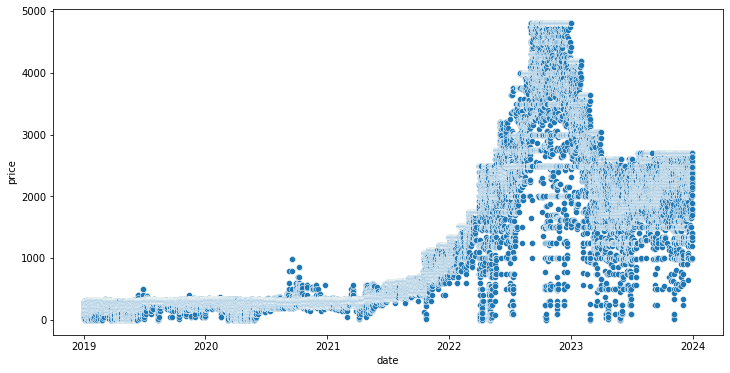

In [28]:
# general view of the data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="date", y="price")

In [64]:
# creating dummy features from date
def add_feature_date(df):
    df["Year"] = df["date"].apply(lambda x:x.year)
    df["Month"] = df["date"].apply(lambda x:x.month)
    df["Quarter"] = df["date"].apply(lambda x:x.quarter)
    df["Dayofyear"] = df["date"].apply(lambda x:x.dayofyear)
    df["Dayofmonth"] = df["date"].apply(lambda x:x.day)
    df["Weekofyear"] = df["date"].apply(lambda x:x.weekofyear)
    df["Weekday"] = df["date"].apply(lambda x:x.weekday())
    return df
df = add_feature_date(df)
df.head()

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday
0,2019-01-01 00:00:00,0,100.38,2019,1,1,1,1,1,1
1,2019-01-01 01:00:00,1,96.72,2019,1,1,1,1,1,1
2,2019-01-01 02:00:00,2,81.60,2019,1,1,1,1,1,1
3,2019-01-01 03:00:00,3,38.58,2019,1,1,1,1,1,1
4,2019-01-01 04:00:00,4,11.52,2019,1,1,1,1,1,1


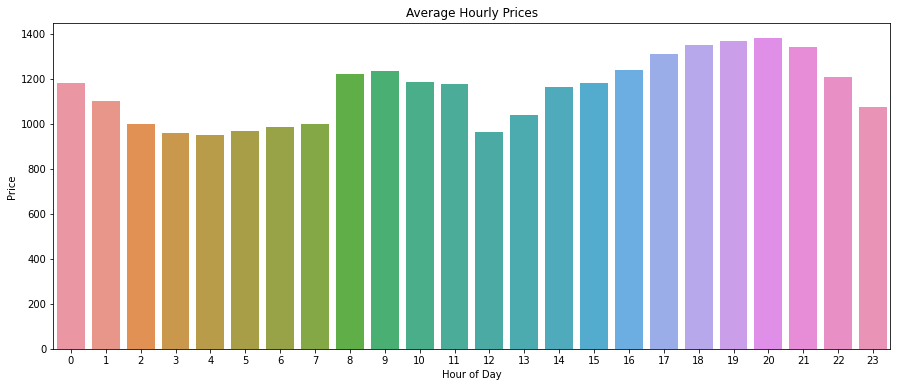

In [30]:
# Hourly pattern
hourly_avg = df.groupby('hour')['price'].mean()

# Plotting hourly average prices
plt.figure(figsize=(15, 6))
sns.barplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title('Average Hourly Prices')
plt.xlabel('Hour of Day')
plt.ylabel('Price')
plt.show()

In [65]:
# after analyzing hourly pattern we can group hours and create new dummy features based on hours
def add_features_hour(df):
    df["Night1"] = df["hour"].apply(lambda x: 1 if 0<=x<=1 else 0)
    df["Night2"] = df["hour"].apply(lambda x: 1 if 2<=x<=7 else 0)
    df["Morning"] = df["hour"].apply(lambda x: 1 if 8<=x<=11 else 0)
    df["Noon"] = df["hour"].apply(lambda x: 1 if x==12 else 0)
    df["Noon2"] = df["hour"].apply(lambda x: 1 if x==13 else 0)
    df["Peak1"] = df["hour"].apply(lambda x: 1 if 14<=x<=16 else 0)
    df["Peak2"] = df["hour"].apply(lambda x: 1 if 17<=x<=21 else 0)
    df["OffPeak1"] = df["hour"].apply(lambda x: 1 if x==22 else 0)
    df["OffPeak2"] = df["hour"].apply(lambda x: 1 if x==23 else 0)
    return df
df = add_features_hour(df)    
df.head()

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,Night1,Night2,Morning,Noon,Noon2,Peak1,Peak2,OffPeak1,OffPeak2
0,2019-01-01 00:00:00,0,100.38,2019,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,1,96.72,2019,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
2,2019-01-01 02:00:00,2,81.60,2019,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0
3,2019-01-01 03:00:00,3,38.58,2019,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0
4,2019-01-01 04:00:00,4,11.52,2019,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0


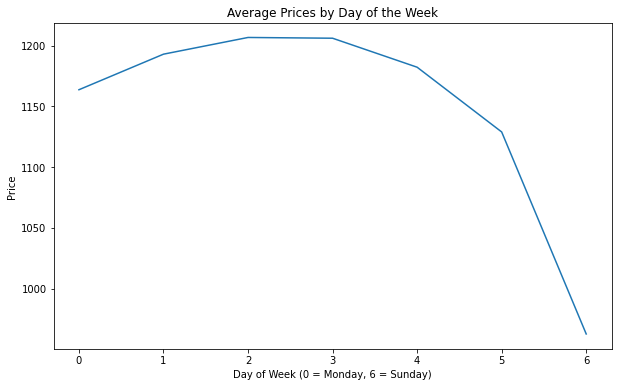

In [32]:
# Day of week aggregation
weekly_avg = df.groupby('Weekday')['price'].mean()

# Plotting daily average prices
plt.figure(figsize=(10, 6))
sns.lineplot(x=weekly_avg.index, y=weekly_avg.values)
plt.title('Average Prices by Day of the Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Price')
plt.show()

In [66]:
# after analyzing weekly pattern we can group weekdays and create new dummy features based on weekdays
def add_features_weekday(df):
    df["Monday"] = df["Weekday"].apply(lambda x: 1 if x==0 else 0)
    df["Midweek"] = df["Weekday"].apply(lambda x: 1 if 1<=x<=3 else 0)
    df["Friday"] = df["Weekday"].apply(lambda x: 1 if x==4 else 0) # Because in Turkiye there are pray hours at noon
    df["Saturday"] = df["Weekday"].apply(lambda x: 1 if x==5 else 0)
    df["Sunday"] = df["Weekday"].apply(lambda x: 1 if x==6 else 0)
    return df
df = add_features_weekday(df)    
df.head()

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,...,Noon2,Peak1,Peak2,OffPeak1,OffPeak2,Monday,Midweek,Friday,Saturday,Sunday
0,2019-01-01 00:00:00,0,100.38,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
1,2019-01-01 01:00:00,1,96.72,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,2019-01-01 02:00:00,2,81.60,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,2019-01-01 03:00:00,3,38.58,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,2019-01-01 04:00:00,4,11.52,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


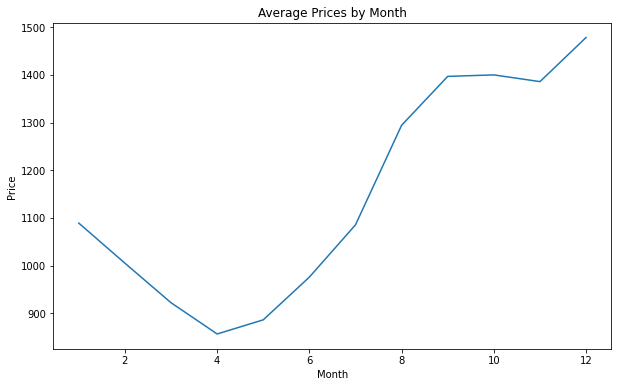

In [67]:
# Monthly aggregation
monthly_avg = df.groupby('Month')['price'].mean()

# Plotting monthly average prices
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Average Prices by Month')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

## It seems that price is lower at summer than winter

In [68]:
df

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,...,Noon2,Peak1,Peak2,OffPeak1,OffPeak2,Monday,Midweek,Friday,Saturday,Sunday
0,2019-01-01 00:00:00,0,100.38,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
1,2019-01-01 01:00:00,1,96.72,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,2019-01-01 02:00:00,2,81.60,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,2019-01-01 03:00:00,3,38.58,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,2019-01-01 04:00:00,4,11.52,2019,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,19,2499.67,2023,12,4,365,31,52,6,...,0,0,1,0,0,0,0,0,0,1
8756,2023-12-31 20:00:00,20,2472.34,2023,12,4,365,31,52,6,...,0,0,1,0,0,0,0,0,0,1
8757,2023-12-31 21:00:00,21,2472.33,2023,12,4,365,31,52,6,...,0,0,1,0,0,0,0,0,0,1
8758,2023-12-31 22:00:00,22,1800.00,2023,12,4,365,31,52,6,...,0,0,0,1,0,0,0,0,0,1


In [36]:
# moving averages
df['daily_avg'] = df['price'].rolling(window=24).mean()  # Daily moving average
df['monthly_avg'] = df['price'].rolling(window=30*24).mean()  # Monthly moving average
df['yearly_avg'] = df['price'].rolling(window=365*24).mean()  # Yearly moving average

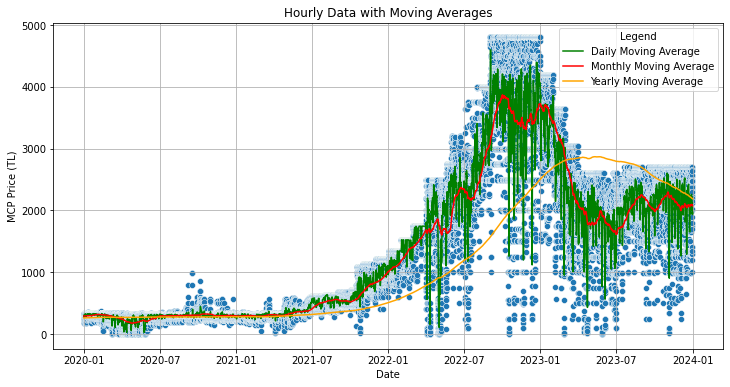

In [37]:
#Visualization of hourly, monthly and yearly moving averages
df_new = df[["date","daily_avg", "monthly_avg", "yearly_avg", "price"]]
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_new.dropna(), x="date",y = "price")
sns.lineplot(data=df_new.dropna(), x="date",y = "daily_avg", color='green', label='Daily Moving Average')
sns.lineplot(data=df_new.dropna(), x="date",y = "monthly_avg", color='red', label='Monthly Moving Average')
sns.lineplot(data=df_new.dropna(), x="date",y = "yearly_avg", color='orange', label='Yearly Moving Average')

plt.title('Hourly Data with Moving Averages')
plt.xlabel('Date')
plt.ylabel('MCP Price (TL)')
plt.legend(title='Legend')
plt.grid()
plt.show()

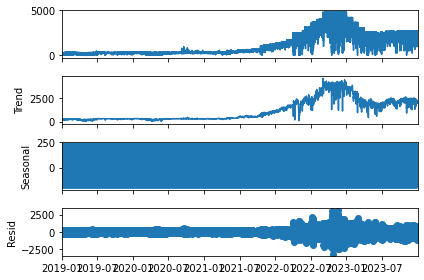

In [38]:
# decompostion to check trend seasonality and residuals
df_decompose = df[["date","price"]]
df_decompose.index = df_decompose["date"]
df_decompose = df_decompose.drop("date",axis=1)
decomposition = seasonal_decompose(df_decompose)

# Plot decomposition
decomposition.plot()
plt.show()

In [39]:
df3 = df[["date", "price"]]
df3.index = df3["date"]
df3 = df3.drop("date",axis=1)
df3

,price
date,
2019-01-01 00:00:00,100.38
2019-01-01 01:00:00,96.72
2019-01-01 02:00:00,81.60
2019-01-01 03:00:00,38.58
2019-01-01 04:00:00,11.52
...,...
2023-12-31 19:00:00,2499.67
2023-12-31 20:00:00,2472.34
2023-12-31 21:00:00,2472.33


In [40]:
# Dickey fuller tests for daily monthly and yearly data
def test_stationary_daily(data):
    rolling_mean = data.rolling(24).mean()
    rolling_std = data.rolling(24).std()
    plt.plot(data, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Mean")
    plt.plot(rolling_std, color="black", label = "Standard Deviation")
    plt.legend(loc="best")
    plt.show()
    
    #Dickey Fuller Test
    adft = adfuller(data,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df) #p>0.05 means not stationary
    
def test_stationary_monthly(data):
    rolling_mean = data.rolling(24*30).mean()
    rolling_std = data.rolling(24*30).std()
    plt.plot(data, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Mean")
    plt.plot(rolling_std, color="black", label = "Standard Deviation")
    plt.legend(loc="best")
    plt.show()
    
    #Dickey Fuller Test
    adft = adfuller(data,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df) #p>0.05 means not stationary
    
def test_stationary_yearly(data):
    rolling_mean = data.rolling(24*365).mean()
    rolling_std = data.rolling(24*365).std()
    plt.plot(data, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Mean")
    plt.plot(rolling_std, color="black", label = "Standard Deviation")
    plt.legend(loc="best")
    plt.show()
    
    #Dickey Fuller Test
    adft = adfuller(data,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df) #p>0.05 means not stationary

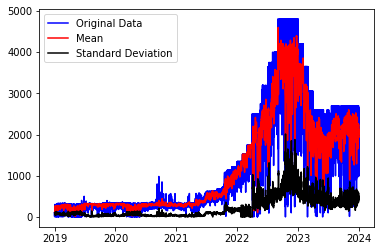

         Values                       Metric
0     -3.874274              Test Statistics
1      0.002233                      p-value
2     55.000000             No. of lags used
3  43768.000000  Number of observations used
4     -3.430499          critical value (1%)
5     -2.861606          critical value (5%)
6     -2.566805         critical value (10%)


In [41]:
test_stationary_daily(df3)

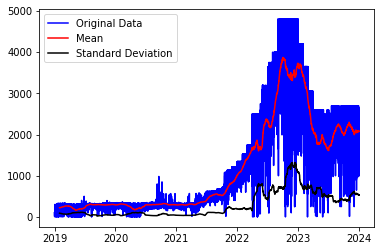

         Values                       Metric
0     -3.874274              Test Statistics
1      0.002233                      p-value
2     55.000000             No. of lags used
3  43768.000000  Number of observations used
4     -3.430499          critical value (1%)
5     -2.861606          critical value (5%)
6     -2.566805         critical value (10%)


In [42]:
test_stationary_monthly(df3)

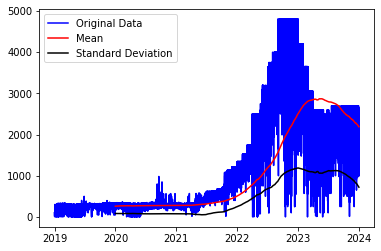

         Values                       Metric
0     -3.874274              Test Statistics
1      0.002233                      p-value
2     55.000000             No. of lags used
3  43768.000000  Number of observations used
4     -3.430499          critical value (1%)
5     -2.861606          critical value (5%)
6     -2.566805         critical value (10%)


In [43]:
test_stationary_yearly(df3)

### p<0.05 so we can say that data is stationary

In [44]:
def plot_lag(x, lag=1, ax=None, **kwargs):
    x_ = x.shift(lag)
    y_ = x
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
    alpha = 0.75,
    s = 3)
    line = dict(color = 'C3')
    
    ax = sns.regplot(x=x_,
                    y=y_,
                    scatter_kws=scatter_kws,
                    line_kws=line,
                    lowess = True,
                    ax=ax,
                    **kwargs 
                    )
    at = AnchoredText(
    f"{y_.corr(x_):.2f}",
    prop=dict(size="large"),
    frameon=True,
    loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lag_rolling(x, lag=1, ax=None, **kwargs):
    x_ = x.rolling(lag).mean()
    y_ = x
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
    alpha = 0.75,
    s = 3)
    line = dict(color = 'C3')
    
    ax = sns.regplot(x=x_,
                    y=y_,
                    scatter_kws=scatter_kws,
                    line_kws=line,
                    lowess = True,
                    ax=ax,
                    **kwargs 
                    )
    at = AnchoredText(
    f"{y_.corr(x_):.2f}",
    prop=dict(size="large"),
    frameon=True,
    loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_autocorrelation(x, lags=6, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault("nrows", 2)
    kwargs.setdefault("ncols", math.ceil(lags / 2))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, 2 * 2 + 0.5))
    fig, axs = plt.subplots(sharex = True, sharey = True, squeeze = False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(2 * kwargs["ncols"])):
        if k + 1 <= lags:
            ax = plot_lag(x, lag = k+1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag #{k+1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

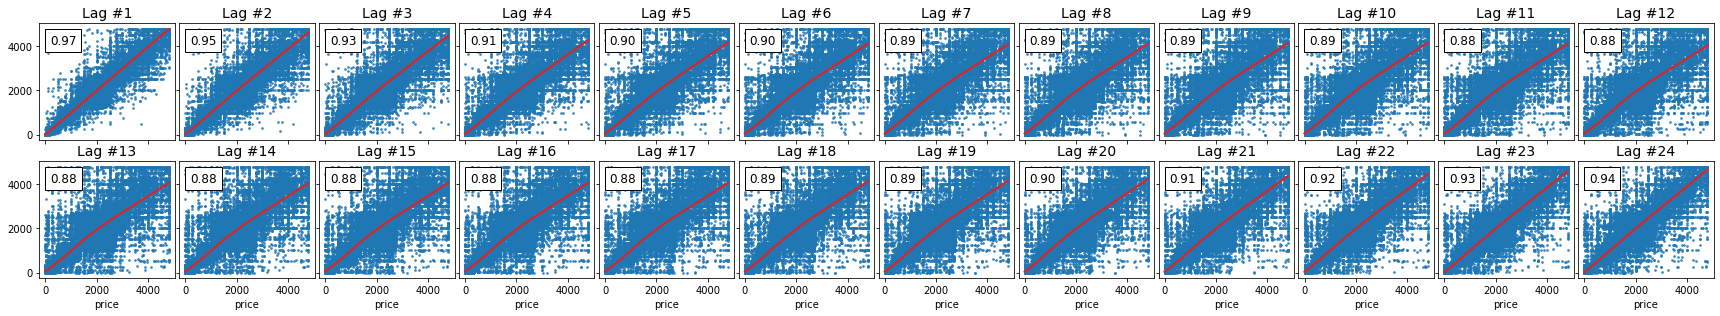

In [45]:
# correlation of 24 hours of lagged values and mcp
_ = plot_autocorrelation(df3["price"],lags=24)

In [4]:
df_sarima = df[["date","price"]].copy()
df_sarima.index = df_sarima["date"]
df_sarima = df_sarima.drop("date",axis=1)
df_sarima["price"] = round(df_sarima["price"],0)

dftest = adfuller(df_sarima.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.8742892188870974
2. P-Value :  0.0022324268788178644
3. Num Of Lags :  55
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 43768
5. Critical Values :
	 1% :  -3.4304994170070295
	 5% :  -2.861606039041269
	 10% :  -2.5668051504336344


## I tried fitting a sarima model many times but my computer did not allow me to do. I got memoryerror many times. Since there is seasonality in data, sarima would be better but I had to use arima

In [5]:
model=pmd.auto_arima(df_sarima,max_p=3,max_q=3,test='adf',seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=611660.673, Time=22.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=743959.170, Time=0.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=615960.831, Time=1.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=695765.587, Time=4.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=773361.236, Time=0.49 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=615025.969, Time=9.72 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=615840.764, Time=13.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=31.70 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=611661.208, Time=26.60 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=615856.295, Time=1.78 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=614755.067, Time=14.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=612336.803, Time=24.63 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=28.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=611600.270, Time=5.98 sec
 ARIMA(1,0,2

In [8]:
model_arima = ARIMA(df_sarima, order=(2, 0, 3))
model_arima_fit = model.fit()

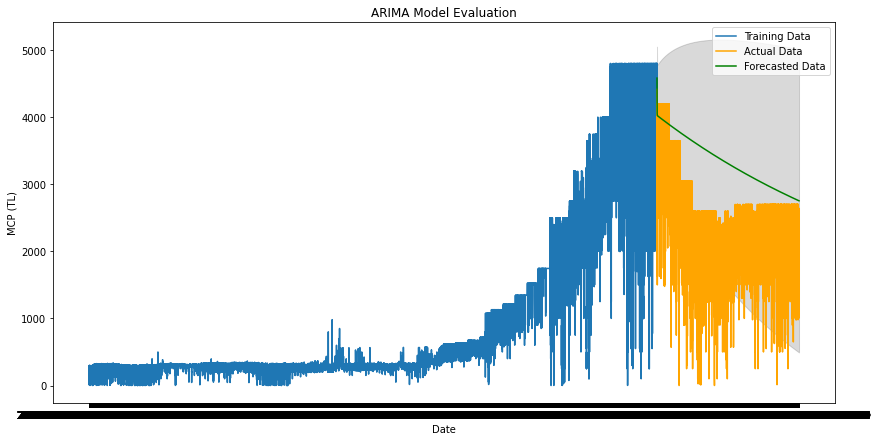

RMSE: 1794139.0317985734
MAE: 1156.9047027209767
R2: -2.4346308610734626


In [229]:
# Split the data into train and test
train_size = int(len(df_sarima) * 0.8)
train, test = df_sarima[0:train_size], df_sarima[train_size:len(df_sarima)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train, order=(2, 0, 3))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test, test_forecast_series)
mae = mean_absolute_error(test, test_forecast_series)
r2_arima = r2_score(test, test_forecast_series)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('MCP (TL)')
plt.legend()
plt.show()

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2_arima)

# MACHINE LEARNING MODELS

## RANDOM FOREST

### To create a machine learning model we need to have lag features. Above correlation of 24 hour lag values with price were calculated. It can be seen that all 24 hours are highly correlated with price.

In [69]:
def lag_features(data):
    period_list = list(range(1,25))# 24 hour lagged list
    temp_data = data["price"]
    
    for period in period_list:
        data[f"lagged_price_{period}"] = temp_data.shift(period)
        
    return data
df = lag_features(df)
df.head()

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,...,lagged_price_15,lagged_price_16,lagged_price_17,lagged_price_18,lagged_price_19,lagged_price_20,lagged_price_21,lagged_price_22,lagged_price_23,lagged_price_24
0,2019-01-01 00:00:00,0,100.38,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,1,96.72,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,2,81.60,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,3,38.58,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,4,11.52,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 0 to 8759
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             43824 non-null  datetime64[ns]
 1   hour             43824 non-null  int64         
 2   price            43824 non-null  float64       
 3   Year             43824 non-null  int64         
 4   Month            43824 non-null  int64         
 5   Quarter          43824 non-null  int64         
 6   Dayofyear        43824 non-null  int64         
 7   Dayofmonth       43824 non-null  int64         
 8   Weekofyear       43824 non-null  int64         
 9   Weekday          43824 non-null  int64         
 10  Night1           43824 non-null  int64         
 11  Night2           43824 non-null  int64         
 12  Morning          43824 non-null  int64         
 13  Noon             43824 non-null  int64         
 14  Noon2            43824 non-null  int64 

In [71]:
# check if lagged values are created well
df.head(25)

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,...,lagged_price_15,lagged_price_16,lagged_price_17,lagged_price_18,lagged_price_19,lagged_price_20,lagged_price_21,lagged_price_22,lagged_price_23,lagged_price_24
0,2019-01-01 00:00:00,0,100.38,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,1,96.72,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,2,81.60,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,3,38.58,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,4,11.52,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-01 05:00:00,5,11.14,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-01-01 06:00:00,6,11.14,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-01-01 07:00:00,7,24.37,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-01-01 08:00:00,8,34.50,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-01-01 09:00:00,9,45.21,2019,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# Random forest model can't handle na values so I dropped them
df_rf = df.dropna()
df_rf

,date,hour,price,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,...,lagged_price_15,lagged_price_16,lagged_price_17,lagged_price_18,lagged_price_19,lagged_price_20,lagged_price_21,lagged_price_22,lagged_price_23,lagged_price_24
24,2019-01-02 00:00:00,0,104.69,2019,1,1,2,2,1,2,...,45.21,34.50,24.37,11.14,11.14,11.52,38.58,81.60,96.72,100.38
25,2019-01-02 01:00:00,1,88.25,2019,1,1,2,2,1,2,...,71.54,45.21,34.50,24.37,11.14,11.14,11.52,38.58,81.60,96.72
26,2019-01-02 02:00:00,2,83.20,2019,1,1,2,2,1,2,...,100.31,71.54,45.21,34.50,24.37,11.14,11.14,11.52,38.58,81.60
27,2019-01-02 03:00:00,3,43.89,2019,1,1,2,2,1,2,...,102.94,100.31,71.54,45.21,34.50,24.37,11.14,11.14,11.52,38.58
28,2019-01-02 04:00:00,4,32.65,2019,1,1,2,2,1,2,...,100.36,102.94,100.31,71.54,45.21,34.50,24.37,11.14,11.14,11.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,19,2499.67,2023,12,4,365,31,52,6,...,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74,2390.00,2115.00,2200.01
8756,2023-12-31 20:00:00,20,2472.34,2023,12,4,365,31,52,6,...,2299.00,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74,2390.00,2115.00
8757,2023-12-31 21:00:00,21,2472.33,2023,12,4,365,31,52,6,...,2498.29,2299.00,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74,2390.00
8758,2023-12-31 22:00:00,22,1800.00,2023,12,4,365,31,52,6,...,2553.80,2498.29,2299.00,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74


In [74]:
X = df_rf.drop(["date","price"],axis=1)
y = df_rf["price"]

Random Forest MSE: 102780.41108821578


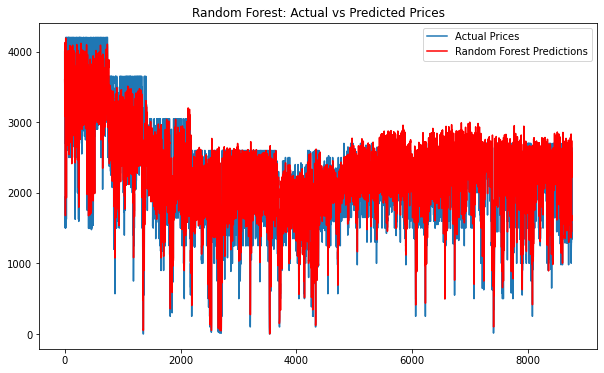

In [75]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred_rf, label='Random Forest Predictions', color='red')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.legend()
plt.show()

In [86]:
r2_rf = r2_score(y_test, y_pred_rf)
r2_rf

0.8027197864796609

In [79]:
# tuning random forest model
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearch to find the best parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=False, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model
best_rf_model = grid_search.best_estimator_

# Predict using the test set
y_pred_best = best_rf_model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}


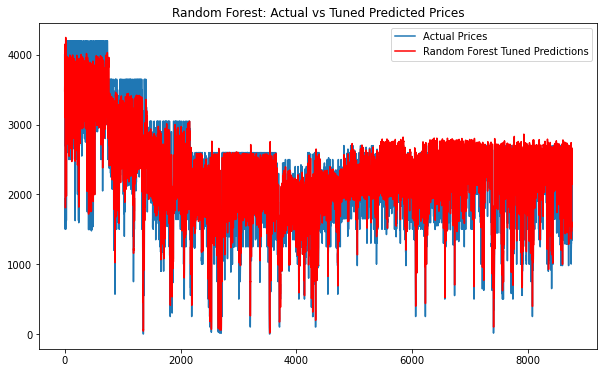

In [80]:
# Plot actual vs tuned predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred_best, label='Random Forest Tuned Predictions', color='red')
plt.title('Random Forest: Actual vs Tuned Predicted Prices')
plt.legend()
plt.show()

In [87]:
# Evaluate model performance
mse_rf_tuned = mean_squared_error(y_test, y_pred_best)
mse_rf_tuned

100904.4253496756

In [226]:
mae_rf_tuned = mean_absolute_error(y_test, y_pred_best)
mae_rf_tuned

231.36441152761162

In [88]:
r2_rf_tuned = r2_score(y_test, y_pred_best)
r2_rf_tuned

0.8063206172521966

Random Forest MSE: 127142.79968047614


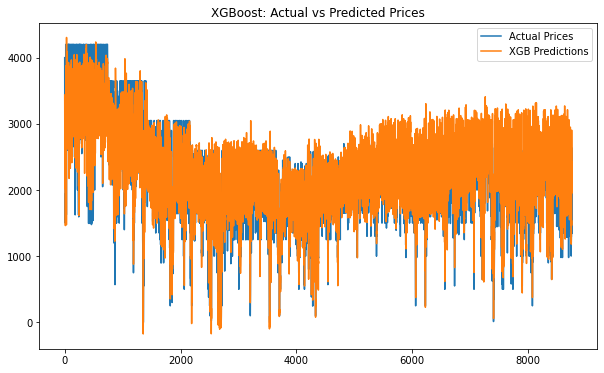

In [84]:
# xgboost model
xgb_model = xgb.XGBRegressor(tree_method = "hist")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Random Forest MSE: {mse_xgb}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred_xgb, label='XGB Predictions')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.legend()
plt.show()

In [244]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_xgb

127142.79968047614

In [245]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mae_xgb

273.27207476528594

In [246]:
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_xgb

0.75595778998189

In [230]:
# tuning xgboost model
param_grid = {
    'n_estimators': [50, 100, 200],
    'subsample':[0.5, 1.0],
    'gamma':[0, 1, 5, 10, 15],
    'max_depth': [3, 4, 5, 10],
    'min_samples_split': [2, 5, 10],
    'learning_rate':[0.1, 0.3, 0.5, 1]
}

# GridSearch to find the best parameters
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=False, n_jobs=-1)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search_xgb.best_params_)

# Use the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Predict using the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)

Best parameters found:  {'gamma': 0, 'learning_rate': 1, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.5}


In [247]:
mse_xgb_tuned = mean_squared_error(y_test, y_pred_best_xgb)
mse_xgb_tuned

226143.10323821288

In [248]:
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_best_xgb)
mae_xgb_tuned

343.05538854313545

In [249]:
r2_xgb_tuned = r2_score(y_test, y_pred_best_xgb)
r2_xgb_tuned

0.5659332433035786

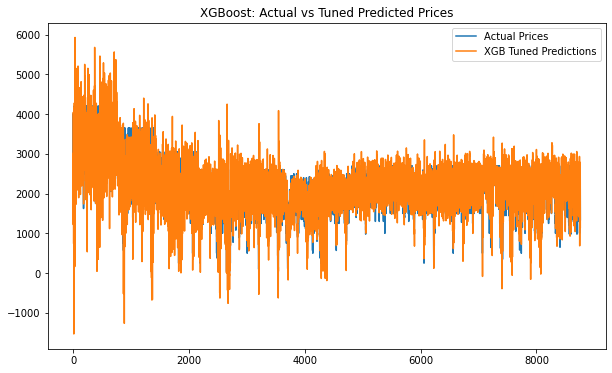

In [232]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred_best_xgb, label='XGB Tuned Predictions')
plt.title('XGBoost: Actual vs Tuned Predicted Prices')
plt.legend()
plt.show()

In [108]:
X

,hour,Year,Month,Quarter,Dayofyear,Dayofmonth,Weekofyear,Weekday,Night1,Night2,...,lagged_price_15,lagged_price_16,lagged_price_17,lagged_price_18,lagged_price_19,lagged_price_20,lagged_price_21,lagged_price_22,lagged_price_23,lagged_price_24
24,0,2019,1,1,2,2,1,2,1,0,...,45.21,34.50,24.37,11.14,11.14,11.52,38.58,81.60,96.72,100.38
25,1,2019,1,1,2,2,1,2,1,0,...,71.54,45.21,34.50,24.37,11.14,11.14,11.52,38.58,81.60,96.72
26,2,2019,1,1,2,2,1,2,0,1,...,100.31,71.54,45.21,34.50,24.37,11.14,11.14,11.52,38.58,81.60
27,3,2019,1,1,2,2,1,2,0,1,...,102.94,100.31,71.54,45.21,34.50,24.37,11.14,11.14,11.52,38.58
28,4,2019,1,1,2,2,1,2,0,1,...,100.36,102.94,100.31,71.54,45.21,34.50,24.37,11.14,11.14,11.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,2023,12,4,365,31,52,6,0,0,...,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74,2390.00,2115.00,2200.01
8756,20,2023,12,4,365,31,52,6,0,0,...,2299.00,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74,2390.00,2115.00
8757,21,2023,12,4,365,31,52,6,0,0,...,2498.29,2299.00,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74,2390.00
8758,22,2023,12,4,365,31,52,6,0,0,...,2553.80,2498.29,2299.00,2149.01,2124.99,1899.99,2379.97,2499.01,1697.01,2017.74


In [233]:
best_rf_model.fit(X,y) # to predict future values, all past data is used

RandomForestRegressor(max_depth=10, max_features='auto', min_samples_split=5,
                      n_estimators=200, random_state=42)

In [234]:
best_xgb_model.fit(X,y) # to predict future values, all past data is used

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, min_samples_split=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [235]:
xgb_model.fit(X,y) # to predict future values, all past data is used

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot:>

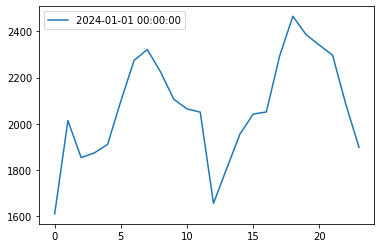

In [236]:
# Prediction of future values Random Forest Model
future_dates = ["2024-01-01 00:00:00"]
df_predict = df.copy().iloc[:,:24]
df_predict_result = pd.DataFrame()
for future_date in future_dates:
    predicted_values = []
    predicted_hours = []
    for i in range(0,24):
        sample_date = datetime.strptime(future_date, "%Y-%m-%d %H:%M:%S") + pd.Timedelta(hours=i)
        
        predicted_hours.append(sample_date)
        sample_df = pd.DataFrame(columns = ["date"], data=[sample_date])
        sample_df["hour"] = list(sample_df["date"].dt.hour.astype("int"))
        
        sample_df = add_feature_date(sample_df)
        sample_df = add_features_hour(sample_df)
        sample_df = add_features_weekday(sample_df)
        
        df_predict = pd.concat([df_predict, sample_df])
        df_predict.index = df_predict["date"]
        df_predict = lag_features(df_predict)
        to_predict = np.array(df_predict[X.columns].iloc[-1,:]).reshape(1,X.shape[1])
        predicted_value = best_rf_model.predict(to_predict)
        #print(predicted_value)
        df_predict.loc[df_predict.index == sample_date, "price"] = predicted_value[0]
        #print(predicted_value[0])
        predicted_values.append(predicted_value)
    df_predict_result.index = list(range(0,24))
    df_predict_result[future_date] = [x[0] for x in predicted_values]

sns.lineplot(data = df_predict_result,dashes=False)

<AxesSubplot:>

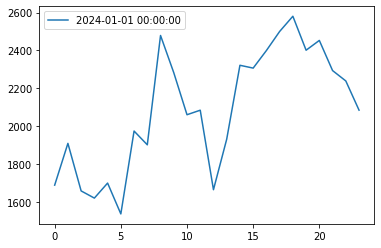

In [242]:
# Prediction of future values XGBoost Model
future_dates = ["2024-01-01 00:00:00"]
df_predict_xgb = df.copy().iloc[:,:24]
df_predict_result_xgb = pd.DataFrame()
for future_date in future_dates:
    predicted_values_xgb = []
    predicted_hours = []
    for i in range(0,24):
        sample_date = datetime.strptime(future_date, "%Y-%m-%d %H:%M:%S") + pd.Timedelta(hours=i)
        
        predicted_hours.append(sample_date)
        sample_df = pd.DataFrame(columns = ["date"], data=[sample_date])
        sample_df["hour"] = list(sample_df["date"].dt.hour.astype("int"))
        
        sample_df = add_feature_date(sample_df)
        sample_df = add_features_hour(sample_df)
        sample_df = add_features_weekday(sample_df)
        
        df_predict_xgb = pd.concat([df_predict_xgb, sample_df])
        df_predict_xgb.index = df_predict_xgb["date"]
        df_predict_xgb = lag_features(df_predict_xgb)
        to_predict_xgb = np.array(df_predict_xgb[X.columns].iloc[-1,:]).reshape(1,X.shape[1])
        predicted_value_xgb = xgb_model.predict(to_predict_xgb)
        #print(predicted_value)
        df_predict_xgb.loc[df_predict_xgb.index == sample_date, "price"] = predicted_value_xgb[0]
        #print(predicted_value[0])
        predicted_values_xgb.append(predicted_value_xgb)
    df_predict_result_xgb.index = list(range(0,24))
    df_predict_result_xgb[future_date] = [x[0] for x in predicted_values_xgb]

sns.lineplot(data = df_predict_result_xgb,dashes=False)

<AxesSubplot:>

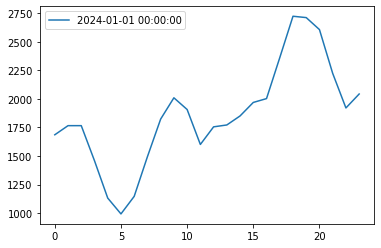

In [239]:
# Prediction of future values XGBoost Model
future_dates = ["2024-01-01 00:00:00"]
df_predict_xgb = df.copy().iloc[:,:24]
df_predict_result_xgb2 = pd.DataFrame()
for future_date in future_dates:
    predicted_values_xgb = []
    predicted_hours = []
    for i in range(0,24):
        sample_date = datetime.strptime(future_date, "%Y-%m-%d %H:%M:%S") + pd.Timedelta(hours=i)
        
        predicted_hours.append(sample_date)
        sample_df = pd.DataFrame(columns = ["date"], data=[sample_date])
        sample_df["hour"] = list(sample_df["date"].dt.hour.astype("int"))
        
        sample_df = add_feature_date(sample_df)
        sample_df = add_features_hour(sample_df)
        sample_df = add_features_weekday(sample_df)
        
        df_predict_xgb = pd.concat([df_predict_xgb, sample_df])
        df_predict_xgb.index = df_predict_xgb["date"]
        df_predict_xgb = lag_features(df_predict_xgb)
        to_predict_xgb = np.array(df_predict_xgb[X.columns].iloc[-1,:]).reshape(1,X.shape[1])
        predicted_value_xgb = best_xgb_model.predict(to_predict_xgb)
        #print(predicted_value)
        df_predict_xgb.loc[df_predict_xgb.index == sample_date, "price"] = predicted_value_xgb[0]
        #print(predicted_value[0])
        predicted_values_xgb.append(predicted_value_xgb)
    df_predict_result_xgb2.index = list(range(0,24))
    df_predict_result_xgb2[future_date] = [x[0] for x in predicted_values_xgb]

sns.lineplot(data = df_predict_result_xgb2,dashes=False)

In [184]:
credentials = {"startDate":f"{2024}-01-01T00:00:00+03:00",
              "endDate":f"{2024}-01-01T00:00:00+03:00"}
headers = {
    "Content-type":"application/json",
    "Accept":"application/json",
    "TGT":tgt
}
# Send the POST request to get the TGT
response = requests.post(mcp_url,headers=headers,json=credentials)
mcp_json = response.json()
df_real = pd.DataFrame(mcp_json["items"])
df_real

,date,hour,price,priceUsd,priceEur
0,2024-01-01T00:00:00+03:00,00:00,1299.98,44.16,39.91
1,2024-01-01T01:00:00+03:00,01:00,1299.98,44.16,39.91
2,2024-01-01T02:00:00+03:00,02:00,1248.54,42.41,38.33
3,2024-01-01T03:00:00+03:00,03:00,1299.98,44.16,39.91
4,2024-01-01T04:00:00+03:00,04:00,1200.00,40.76,36.84
5,2024-01-01T05:00:00+03:00,05:00,1200.00,40.76,36.84
6,2024-01-01T06:00:00+03:00,06:00,1248.54,42.41,38.33
7,2024-01-01T07:00:00+03:00,07:00,1299.99,44.16,39.91
8,2024-01-01T08:00:00+03:00,08:00,1299.99,44.16,39.91
9,2024-01-01T09:00:00+03:00,09:00,1399.98,47.56,42.98


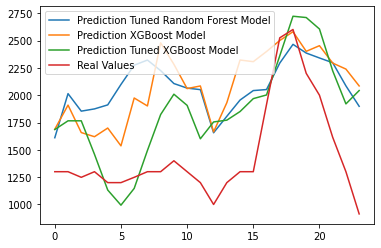

In [243]:
# prediction of future values vs real values for date=2024-01-01
plt.plot(df_predict_result,label="Prediction Tuned Random Forest Model")
plt.plot(df_predict_result_xgb,label="Prediction XGBoost Model")
plt.plot(df_predict_result_xgb2,label="Prediction Tuned XGBoost Model")
plt.plot(df_real["price"],label="Real Values")
plt.legend()
plt.show()